# Demo of VAE for anomaly detection of diverse sensor data
Trained on non-fault data to learn a normal expectation.

Build the model for 512 time points per cycle with 14 sensors.

In [1]:
%matplotlib inline

In [2]:
from IPython.core.debugger import set_trace

In [3]:
from demo import *
device

device(type='cuda', index=0)

In [93]:
desc

'valve'

In [4]:
model = VAE1D(size, n_channels, n_latent)
model = model.to(device)
print(f"Time-series size = {size}, number of sensors = {n_channels}, "
      f"latent size = {n_latent}")

Time-series size = 512, number of sensors = 14, latent size = 50


Load the best parameters from training.

In [5]:
model = load_checkpoint(model, device)

Checkpoint Performance:
Validation loss: 8.832
Epoch: 269


In [6]:
params = model.demo()

Input size: torch.Size([1, 14, 512])
Encoded size: torch.Size([1, 1024, 4])
Latent size: torch.Size([1, 50, 1])
Decoded (output) size: torch.Size([1, 14, 512])


In [7]:
X, E, L, D = [param.cpu().detach().numpy() for param in params]
MSE = np.power((X - D), 2).sum() / 2
print(f"MSE of random data = {MSE:.3f}")

MSE of random data = 728.138


In [8]:
X[:, :4, :4]

array([[[0.34664372, 0.89619905, 0.01862701, 0.51579577],
        [0.28431326, 0.7212294 , 0.9014824 , 0.9785872 ],
        [0.16863449, 0.13546303, 0.61611956, 0.0131522 ],
        [0.1307541 , 0.45133656, 0.34468067, 0.24068953]]], dtype=float32)

In [9]:
D[:, :4, :4]

array([[[ 0.3644208 ,  0.37039265,  0.38497165,  0.4932818 ],
        [ 0.22057398, -0.01547452, -0.06323627, -0.01637756],
        [ 0.66688156,  0.8407916 ,  0.7736392 ,  0.7485776 ],
        [ 0.3166718 ,  0.49562028,  0.6533722 ,  0.7631951 ]]],
      dtype=float32)

Next we need to load the datasets of sensors readings.

In [10]:
data_path = Path(f'data/hydraulic/{desc}')
train_dl, val_dl, test_dl = load_datasets(data_path)

In [11]:
print(len(train_dl), len(val_dl), len(test_dl))

38 10 720


Let's get some random samples from the dataset for examples and generate new versions.

In [12]:
data, targets = get_random_samples(test_dl)

In [13]:
classes = list_target_classes(test_dl)

0 = fail
1 = norm


In [14]:
targets = targets.cpu().numpy()
targets[:10]

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [16]:
print('normals = ', targets.sum())

normals =  360


In [17]:
print('failures = ', len(targets) - targets.sum())

failures =  360


In [18]:
criterion = VAE1DLoss()
criterion = criterion.to(device)

In [19]:
model.eval()
with torch.no_grad():
    # Generate
    data = data.to(device)
    gen_data, mu, logvar = model(data)
    loss, loss_desc = criterion(gen_data, data, mu, logvar, reduce=False)
    

In [20]:
gen_err = -loss_desc['logp']
gen_err[:10]

tensor([153.4822,   5.2402, 244.7505,   4.2477, 273.9109, 242.3102, 279.9996,
        273.6044,   3.8920,   4.6582], device='cuda:0')

[[ 0.08299944  0.05297679  0.06761724  0.06167421  0.09167978]
 [ 0.03653094  0.01846082  0.0288782   0.01153185  0.01235412]
 [ 0.27331108  0.1924017   0.2084533   0.18859607  0.2022708 ]
 [ 0.05020168  0.04951641  0.07430452  0.09924519  0.1807617 ]
 [ 0.05397859  0.00402791 -0.00388162 -0.00650498 -0.01521776]]
MSE = 153.48219299316406


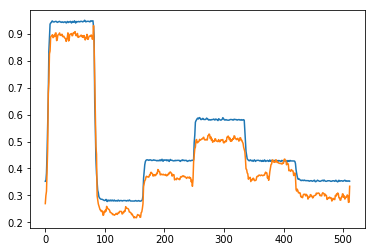

In [21]:
idx = 0
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :])
plt.plot(gen_sample[0, :])
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

[[ 0.0079338   0.0043107   0.01538846 -0.0260984   0.00806195]
 [ 0.01647623  0.00187006  0.02856102  0.00379392 -0.00090223]
 [ 0.08179361  0.04740638  0.03218961 -0.01788276 -0.0081225 ]
 [ 0.02346444  0.02597615  0.02737001  0.05737209  0.1536448 ]
 [ 0.01453039  0.01212005  0.03272402  0.00748806 -0.01850893]]
MSE = 5.240173816680908


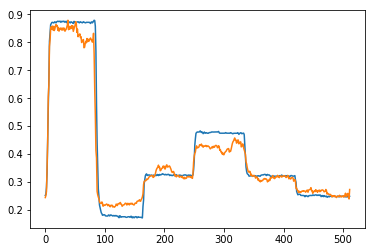

In [22]:
idx = 1
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :])
plt.plot(gen_sample[0, :])
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

In [23]:
err = np.zeros(targets.shape)
for i, target in enumerate(targets):
    err[i] = -loss_desc['logp'][i]
    print(f"Target = {target}, MSE = {err[i]:.3f}")
    if i > 10:
        break

Target = 1, MSE = 153.482
Target = 0, MSE = 5.240
Target = 0, MSE = 244.751
Target = 0, MSE = 4.248
Target = 0, MSE = 273.911
Target = 0, MSE = 242.310
Target = 1, MSE = 280.000
Target = 0, MSE = 273.604
Target = 1, MSE = 3.892
Target = 0, MSE = 4.658
Target = 1, MSE = 80.023
Target = 1, MSE = 179.156


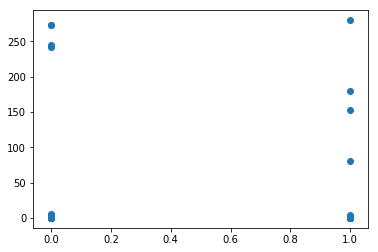

In [24]:
plt.scatter(targets, err)

Show the data plots.

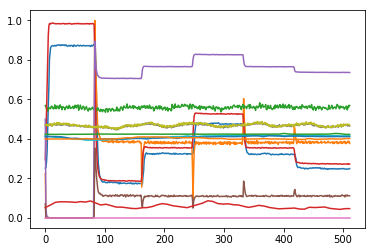

In [25]:
show_plot(sample)

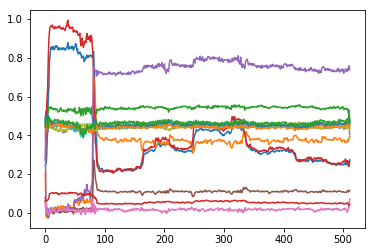

In [26]:
show_plot(gen_sample)

Let's score the success of the recreation and look for outliers.

In [27]:
scores = score(test_dl, model, criterion)

100%|██████████| 720/720 [00:04<00:00, 148.56it/s]


In [28]:
test_means = pd.DataFrame()
for (name, cls), item in scores.items():
    test_means.loc[name, cls] = np.array(item).mean()

print("###################### TEST MEANS #####################")
print(test_means)

###################### TEST MEANS #####################
             fail        norm
loss   662.332742  142.493286
KL     498.409075   21.893820
error  163.923687  120.599466


In [29]:
val_means = pd.DataFrame()
for (name, cls), item in score(val_dl, model, criterion).items():
    val_means.loc[name, cls] = np.array(item).mean()

print("###################### VAL MEANS #####################")
print(val_means)

100%|██████████| 10/10 [00:01<00:00,  5.75it/s]

###################### VAL MEANS #####################
             norm
loss   130.411053
KL      21.922295
error  108.488758


In [30]:
train_means = pd.DataFrame()
for (name, cls), item in score(train_dl, model, criterion).items():
    train_means.loc[name, cls] = np.array(item).mean()

print("###################### TRAIN MEANS #####################")
print(train_means)

100%|██████████| 38/38 [00:06<00:00,  5.94it/s]

###################### TRAIN MEANS #####################
             norm
loss   132.640175
KL      21.538787
error  111.101388


Let's calculate AUC to judge performance.

In [31]:
scores.keys()

dict_keys([('loss', 'fail'), ('loss', 'norm'), ('KL', 'fail'), ('KL', 'norm'), ('error', 'fail'), ('error', 'norm')])

In [32]:
print(len(scores[('error', 'norm')]), len(scores[('error', 'fail')]))

360 360


In [77]:
# simple definition of the threshold as mean between sets
threshold = (np.mean(scores['error', 'fail']) +
             np.mean(scores['error', 'norm'])) / 2
print('mean threshold:', threshold)
# maximum 95% percentile of normal as threshold
# threshold = np.percentile(scores['error', 'norm'], 95)
# print('95th percentile threshold:', threshold)

mean threshold: 142.26157622072432


In [78]:
t_scores = scores.copy()
t_scores[('error', 'fail')] = (t_scores[('error', 'fail')] > threshold)
t_scores[('error', 'norm')] = (t_scores[('error', 'norm')] > threshold)

t_score = []
t_score.extend(t_scores[('error', 'fail')])
t_score.extend(t_scores[('error', 'norm')])
t_score = np.array(t_score)

y_true = []
y_true.extend([True] * len(t_scores[('error', 'fail')]))
y_true.extend([False] * len(t_scores[('error', 'norm')]))
y_true = np.array(y_true)

In [79]:
t_corr = t_score == y_true
t_corr.sum() / len(t_corr)

0.5875

In [82]:
f1_score(y_true, t_score)

0.5892116182572613

In [80]:
auc_scores = auc_score(test_dl, t_scores)
auc_scores

0.5874999999999999

In [83]:
np.mean(scores['error', 'norm'])

120.59946579535803

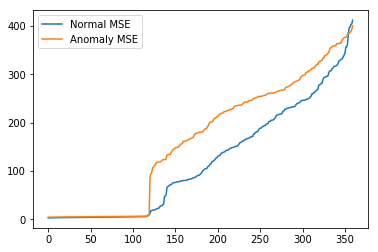

In [84]:
normaly = sorted(scores[('error', 'norm')])
anomaly = sorted(scores[('error', 'fail')])
plt.plot(normaly, label='Normal MSE')
plt.plot(anomaly, label='Anomaly MSE')
plt.legend()

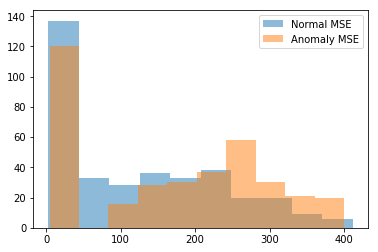

In [85]:
plt.hist(normaly, label='Normal MSE', alpha=0.5)
plt.hist(anomaly, label='Anomaly MSE', alpha=0.5)
plt.legend()

In [86]:
normalx = np.random.rand(len(normaly))
anomalx = np.random.rand(len(anomaly))

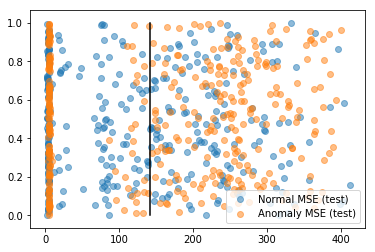

In [87]:
plt.scatter(normaly, normalx, label='Normal MSE (test)', alpha=0.5)
plt.scatter(anomaly, anomalx, label='Anomaly MSE (test)', alpha=0.5)
plt.plot([threshold, threshold], [0, 1], 'k-')
plt.legend()

Try fitting a normal distribution to the validation MSE to define a threshold.

In [88]:
val_scores = score(val_dl, model, criterion)

100%|██████████| 10/10 [00:01<00:00,  5.29it/s]


In [89]:
val_scores.keys()

dict_keys([('loss', 'norm'), ('KL', 'norm'), ('error', 'norm')])

[2.7733242511749268, 2.968562126159668, 2.9910879135131836, 3.007446050643921, 3.0684266090393066]
mean=108.49, stdev=107.68


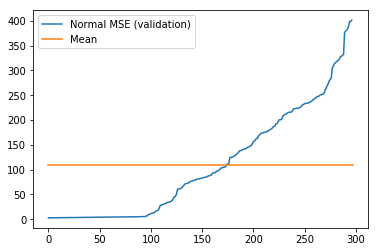

In [90]:
val_norm = sorted(val_scores[('error', 'norm')])
print(val_norm[:5])
mean = np.mean(val_norm)
std = np.std(val_norm)
print('mean={:.2f}, stdev={:.2f}'.format(mean, std))
plt.plot(val_norm, label= 'Normal MSE (validation)')
plt.plot([0, len(val_norm)], [mean, mean], label='Mean')
plt.legend()

Implement PCA to visualize the latent space.

In [91]:
latents, targets = compute_latent(test_dl, model)

100%|██████████| 720/720 [00:04<00:00, 145.82it/s]


In [46]:
from sklearn.decomposition import PCA

In [47]:
pca = PCA(n_components=2)

In [48]:
lat_pca = pca.fit_transform(latents)

In [49]:
lat_pca.shape

(720, 2)

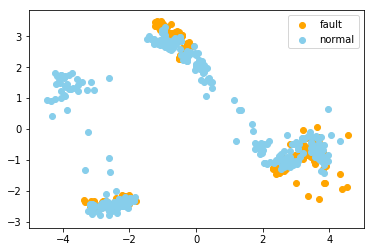

In [50]:
fail_mask = targets == 0
norm_mask = targets == 1
plt.scatter(lat_pca[fail_mask, 0], lat_pca[fail_mask, 1],
            c='orange', label='fault')
plt.scatter(lat_pca[norm_mask, 0], lat_pca[norm_mask, 1],
            c='skyblue', label='normal')
plt.legend()

In [51]:
pca.explained_variance_ratio_

array([0.3505298 , 0.25177068], dtype=float32)

Cluster the latent space into kmeans clusters.

In [52]:
from sklearn.cluster import KMeans

In [53]:
kmeans = KMeans(3)

In [54]:
lat_k = kmeans.fit_transform(latents)

In [55]:
lat_k.shape

(720, 3)

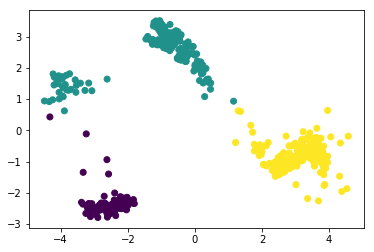

In [56]:
plt.scatter(lat_pca[:, 0], lat_pca[:, 1], c=kmeans.labels_)

Try adding the error terms to the latent features.

In [57]:
latents, kl, error, targets = compute_latent_and_loss(test_dl, model, criterion)

100%|██████████| 720/720 [00:04<00:00, 150.26it/s]


In [58]:
print(latents.shape, kl.shape, error.shape, targets.shape)

(720, 50) (720,) (720,) (720,)


In [59]:
features = np.hstack([latents, kl[:, None], error[:, None]])
features.shape

(720, 52)

In [60]:
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(features)
lat_pca.shape

(720, 2)

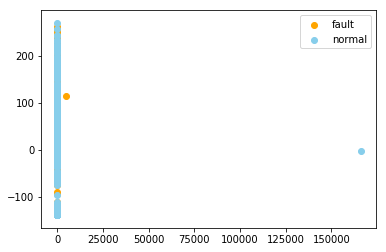

In [61]:
plt.scatter(lat_pca[fail_mask, 0], lat_pca[fail_mask, 1],
            c='orange', label='fault')
plt.scatter(lat_pca[norm_mask, 0], lat_pca[norm_mask, 1],
            c='skyblue', label='normal')
plt.legend()

In [62]:
pca.explained_variance_ratio_

array([9.99608665e-01, 3.90964892e-04])

Compare the pca plots for validation and training sets.

100%|██████████| 38/38 [00:06<00:00,  6.08it/s]


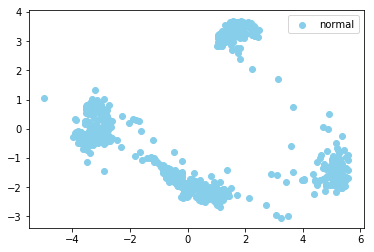

In [63]:
latents, targets = compute_latent(train_dl, model)
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(latents)
plt.scatter(lat_pca[:, 0], lat_pca[:, 1],
            c='skyblue', label='normal')
plt.legend()

100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


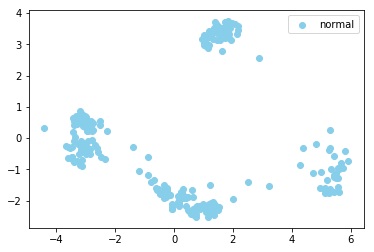

In [64]:
latents, targets = compute_latent(val_dl, model)
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(latents)
plt.scatter(lat_pca[:, 0], lat_pca[:, 1],
            c='skyblue', label='normal')
plt.legend()

Combine the validation plot with the test plot to understand global structure.

In [65]:
latents, targets = compute_latent(train_dl, model)
pca = PCA(n_components=2)
train_pca = pca.fit_transform(latents)

100%|██████████| 38/38 [00:06<00:00,  6.09it/s]


In [66]:
latents, targets = compute_latent(val_dl, model)
val_pca = pca.transform(latents)

100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


In [67]:
latents, targets = compute_latent(test_dl, model)
test_pca = pca.transform(latents)
fail_mask = targets == 0
norm_mask = targets == 1

100%|██████████| 720/720 [00:04<00:00, 149.91it/s]


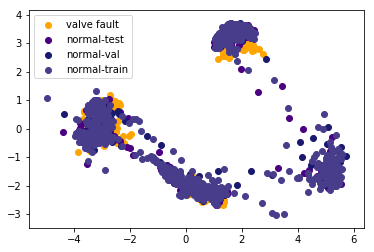

In [68]:
plt.scatter(test_pca[fail_mask, 0], test_pca[fail_mask, 1],
            c='orange', label=desc + ' fault')
plt.scatter(test_pca[norm_mask, 0], test_pca[norm_mask, 1],
            c='indigo', label='normal-test')
plt.scatter(val_pca[:, 0], val_pca[:, 1],
            c='midnightblue', label='normal-val')
plt.scatter(train_pca[:, 0], train_pca[:, 1],
            c='darkslateblue', label='normal-train')
plt.legend()

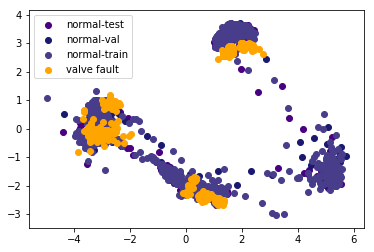

In [92]:
plt.scatter(test_pca[norm_mask, 0], test_pca[norm_mask, 1],
            c='indigo', label='normal-test')
plt.scatter(val_pca[:, 0], val_pca[:, 1],
            c='midnightblue', label='normal-val')
plt.scatter(train_pca[:, 0], train_pca[:, 1],
            c='darkslateblue', label='normal-train')
plt.scatter(test_pca[fail_mask, 0], test_pca[fail_mask, 1],
            c='orange', label=desc + ' fault')
plt.legend()